In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from shap import plots, Explanation, DeepExplainer
from sklearn.preprocessing import StandardScaler
import time
import shap
from tqdm import tqdm
import pickle
from sklearn.cluster import KMeans
from utils import *
from mlp import MLP
import torch
from yellowbrick.model_selection import LearningCurve

pd.set_option('display.max_columns', None)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Here I force the model to run on cpu since it's a small one is goes faster on a cpu then a gpu
device = 'cpu'

In [3]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [8]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


ricordarsi di fare fit una volta sola per tutti i dati e poi usare transform dove serve

In [9]:
scaler = StandardScaler()
scaler.fit(ds[x_features])

StandardScaler()

In [10]:
model = MLP(epoch=320, verbose=True)

params = {
    'epoch': 320,
    'verbose': False,
    'n_features': 79
}

pv = DataPreprocessingAndValidation(ds, 7988, 5, MLP, params, scaler)

In [11]:
X_res, y_res = pv.get_undersampled_ds()
scaled_X_res = scaler.transform(X_res)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=ds.loc[y_res.index].traffic_category)

Epoch [1/320], Loss: 0.6874801516532898
Epoch [2/320], Loss: 0.6598991751670837
Epoch [3/320], Loss: 0.6169538497924805
Epoch [4/320], Loss: 0.5702903866767883
Epoch [5/320], Loss: 0.5303269028663635
Epoch [6/320], Loss: 0.5070980191230774
Epoch [7/320], Loss: 0.49198341369628906
Epoch [8/320], Loss: 0.47661644220352173
Epoch [9/320], Loss: 0.4608461558818817
Epoch [10/320], Loss: 0.44457846879959106
Epoch [11/320], Loss: 0.42946571111679077
Epoch [12/320], Loss: 0.4173325300216675
Epoch [13/320], Loss: 0.406078964471817
Epoch [14/320], Loss: 0.39495566487312317
Epoch [15/320], Loss: 0.38543596863746643
Epoch [16/320], Loss: 0.3765071630477905
Epoch [17/320], Loss: 0.36836811900138855
Epoch [18/320], Loss: 0.36059072613716125
Epoch [19/320], Loss: 0.35342907905578613
Epoch [20/320], Loss: 0.3472643494606018
Epoch [21/320], Loss: 0.34110358357429504
Epoch [22/320], Loss: 0.3361351788043976
Epoch [23/320], Loss: 0.3315753936767578
Epoch [24/320], Loss: 0.32729241251945496
Epoch [25/320],

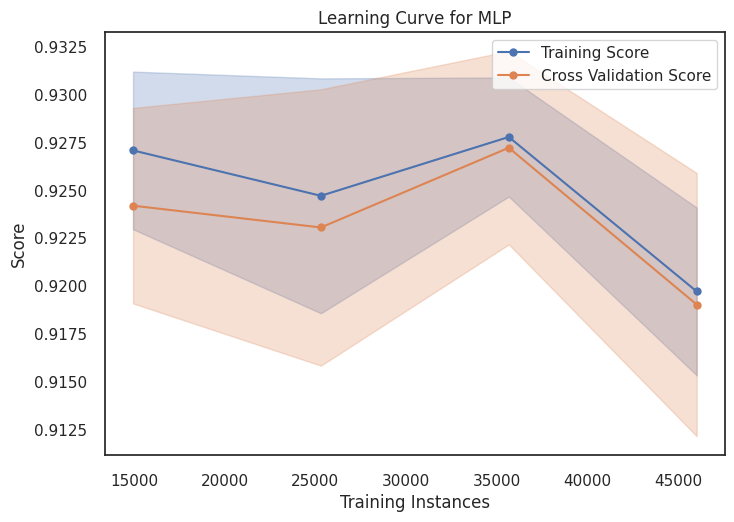

In [13]:
if True:
    cv = 10
    visualizer = LearningCurve(estimator=model, cv=cv, scoring='f1', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="mlp_data/learning_curve.png")


In [14]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Setting the first layer to 79 neurons
Running the cross validation
No improvement for 10 epochs, stopping.
Execution time:  5.468563795089722
No improvement for 10 epochs, stopping.
Execution time:  10.183611154556274
No improvement for 10 epochs, stopping.
Execution time:  13.92831015586853
No improvement for 10 epochs, stopping.
Execution time:  39.949286222457886
No improvement for 10 epochs, stopping.
Execution time:  15.176055908203125
CPU times: user 5min 38s, sys: 1.16 s, total: 5min 39s
Wall time: 1min 26s


(0.9049930876351612, 0.042696498486581566, 85.97578048706055)

In [15]:
model.fit(X_train, y_train)

Epoch [1/320], Loss: 0.6672766208648682
Epoch [2/320], Loss: 0.4263365566730499
Epoch [3/320], Loss: 0.35265716910362244
Epoch [4/320], Loss: 0.3325398862361908
Epoch [5/320], Loss: 0.3155737817287445
Epoch [6/320], Loss: 0.29897579550743103
Epoch [7/320], Loss: 0.2863579988479614
Epoch [8/320], Loss: 0.2740395963191986
Epoch [9/320], Loss: 0.2637251615524292
Epoch [10/320], Loss: 0.2560817003250122
Epoch [11/320], Loss: 0.2500420808792114
Epoch [12/320], Loss: 0.244314506649971
Epoch [13/320], Loss: 0.2394305169582367
Epoch [14/320], Loss: 0.23499172925949097
Epoch [15/320], Loss: 0.23028741776943207
Epoch [16/320], Loss: 0.22876612842082977
Epoch [17/320], Loss: 0.2244485765695572
Epoch [18/320], Loss: 0.22357454895973206
Epoch [19/320], Loss: 0.22077018022537231
Epoch [20/320], Loss: 0.21974113583564758
Epoch [21/320], Loss: 0.21913732588291168
Epoch [22/320], Loss: 0.21708601713180542
Epoch [23/320], Loss: 0.2164963185787201
Epoch [24/320], Loss: 0.21667371690273285
Epoch [25/320],

In [16]:
y_predicted_test = model.predict(X_test)
y_predicted_train = model.predict(X_train)

In [17]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.924144,0.922307
1,PRECISION,0.876428,0.874653
2,RECALL,0.987520,0.985918
3,F1 SCORE,0.928663,0.926958
4,AUC,0.924145,0.922302


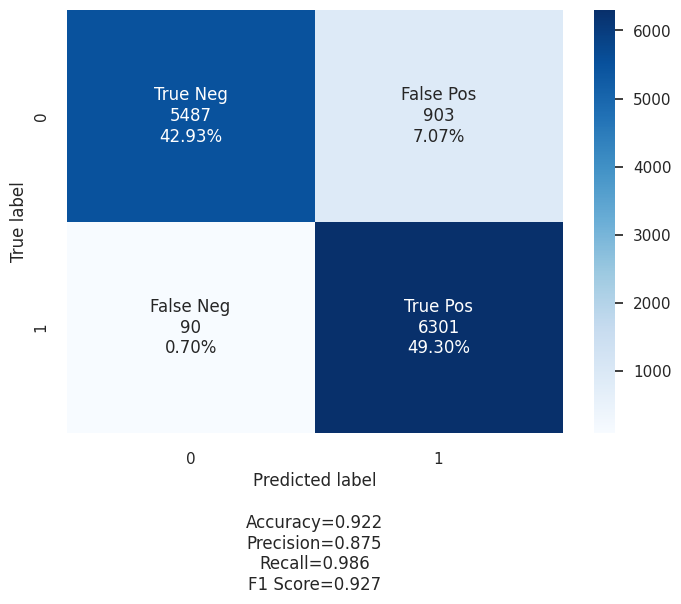

In [18]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [19]:
scaled_X_train = scaler.transform(X_train)

X does not have valid feature names, but StandardScaler was fitted with feature names


In [20]:
cluster_centers = KMeans(n_clusters=1000, random_state=0).fit(scaled_X_train).cluster_centers_
cluster_centers = torch.from_numpy(cluster_centers.astype(np.float32)).to(device)

foreground = shap.sample(X_train, 1000)
foreground_tensor = torch.from_numpy(foreground.astype(np.float32)).to(device)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [21]:
%%time

explainer = DeepExplainer(model, cluster_centers)
sv = explainer.shap_values(foreground_tensor)

exp = Explanation(sv,
              explainer.expected_value,
              data=foreground, 
              feature_names=x_features)

CPU times: user 1min 12s, sys: 95.6 ms, total: 1min 12s
Wall time: 21.8 s


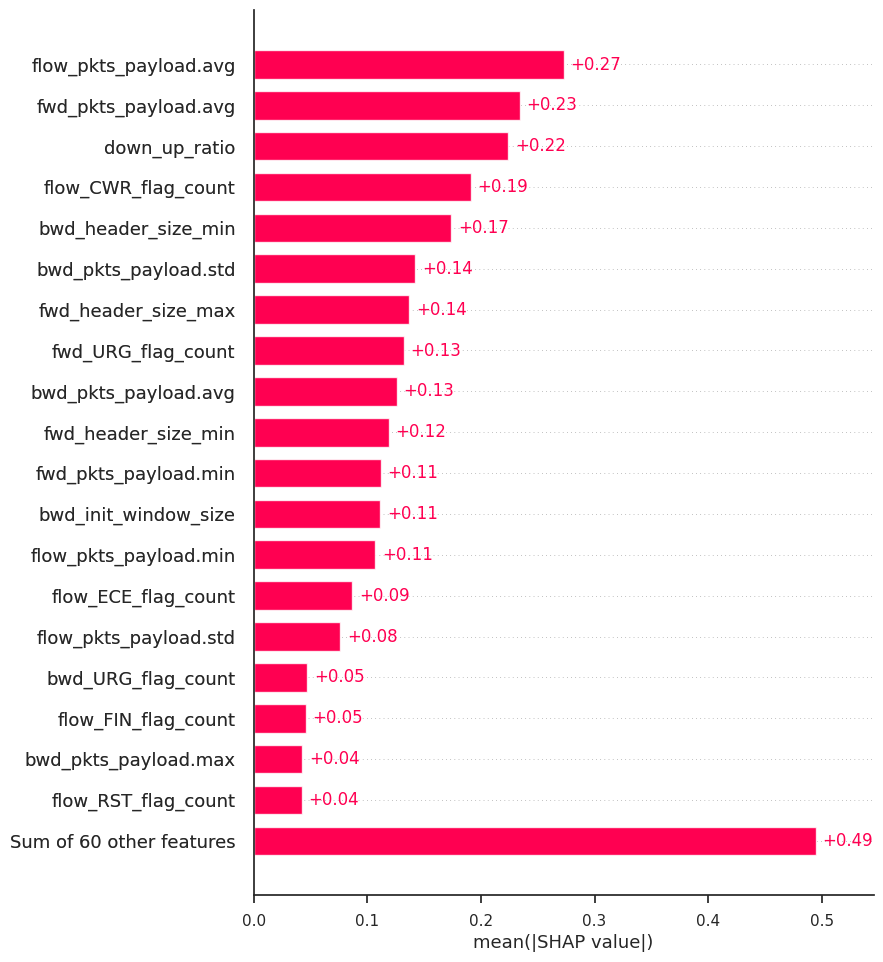

In [22]:
plots.bar(exp, max_display=20, show=False)
plt.show()

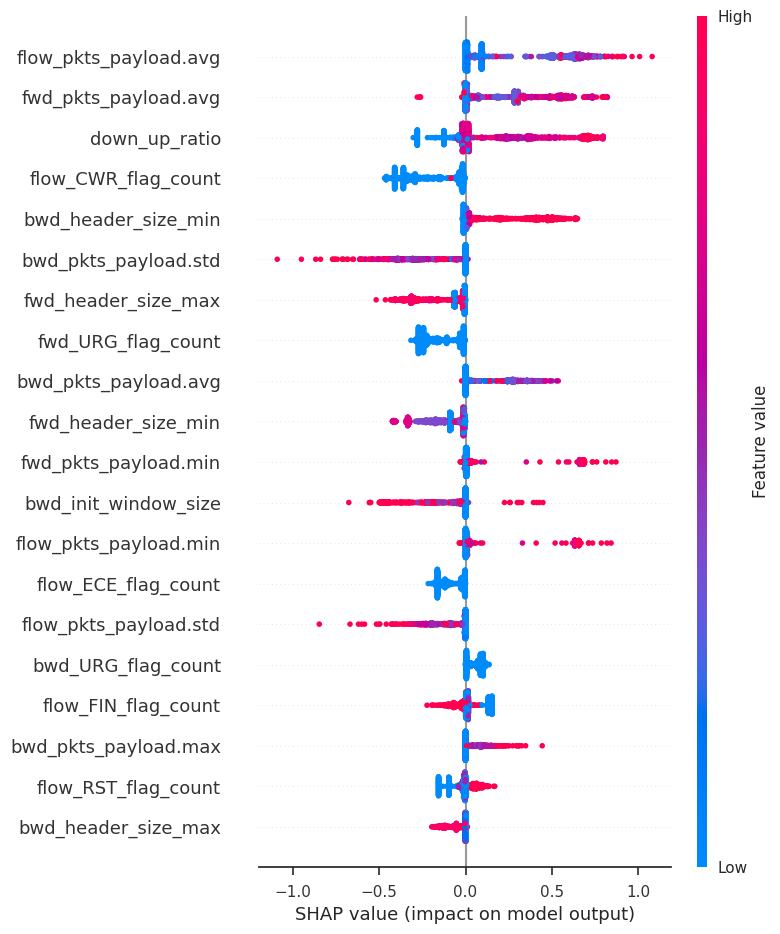

In [23]:
shap.summary_plot(exp, max_display=20)

In [24]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
38,0.273041,flow_pkts_payload.avg
28,0.234300,fwd_pkts_payload.avg
8,0.224190,down_up_ratio
23,0.191287,flow_CWR_flag_count
13,0.173833,bwd_header_size_min
34,0.142178,bwd_pkts_payload.std
11,0.136861,fwd_header_size_max
21,0.132264,fwd_URG_flag_count
33,0.125823,bwd_pkts_payload.avg
10,0.119055,fwd_header_size_min


In [25]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [26]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('mlp_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('mlp_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

Setting the first layer to 1 neurons
Running the cross validation
No improvement for 10 epochs, stopping.
Execution time:  16.734450340270996
No improvement for 10 epochs, stopping.
Execution time:  35.2086706161499
No improvement for 10 epochs, stopping.
Execution time:  8.808861255645752
No improvement for 10 epochs, stopping.
Execution time:  20.531243801116943
No improvement for 10 epochs, stopping.
Execution time:  47.8325035572052
testing with 79 features
Setting the first layer to 79 neurons
Running the cross validation
No improvement for 10 epochs, stopping.
Execution time:  13.26268482208252
No improvement for 10 epochs, stopping.
Execution time:  7.693132638931274
No improvement for 10 epochs, stopping.
Execution time:  26.2922625541687
No improvement for 10 epochs, stopping.
Execution time:  13.34768557548523
No improvement for 10 epochs, stopping.
Execution time:  5.438129901885986
testing with 78 features
Setting the first layer to 78 neurons
Running the cross validation
N

<Axes: xlabel='n_features', ylabel='cv_time'>

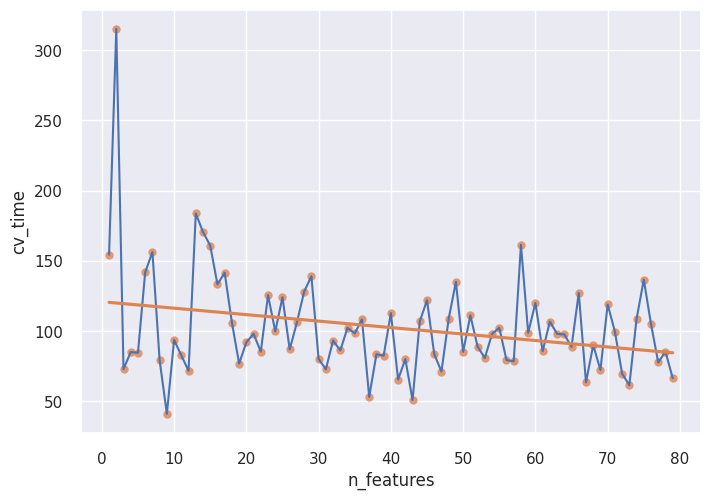

In [28]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

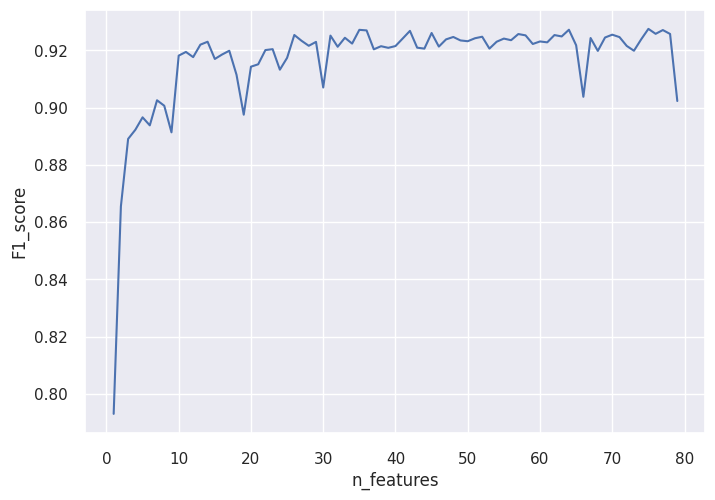

In [29]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

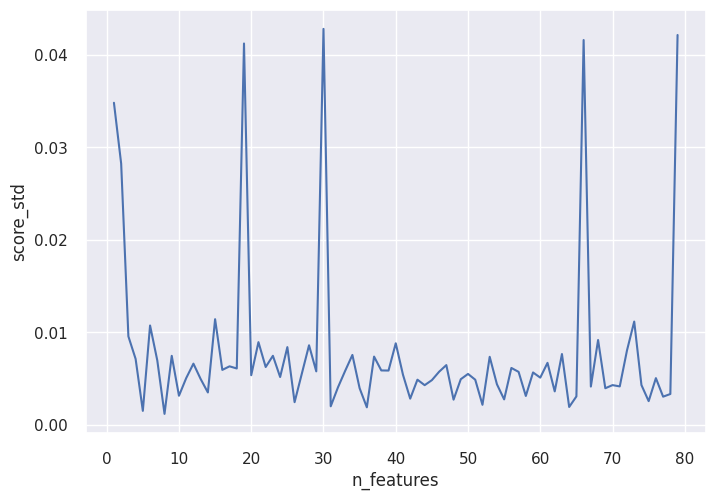

In [30]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [31]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
4,0.927444,0.002565,75,136.671288
15,0.927139,0.001934,64,97.639369
44,0.927108,0.003963,35,98.378385
2,0.927030,0.003048,77,77.704494
43,0.926908,0.001897,36,108.443774
...,...,...,...,...
75,0.892228,0.007129,4,85.107955
70,0.891327,0.007460,9,41.104685
76,0.889040,0.009566,3,72.995420
77,0.865492,0.028242,2,315.237406


In [27]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('mlp_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('mlp_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 79 features
Running the stratified 5-fold
Test and Train k-fold created
Setting the first layer to 79 neurons
Running the cross validation
No improvement for 10 epochs, stopping.
Execution time:  11.208368301391602
No improvement for 10 epochs, stopping.
Execution time:  34.91345691680908
No improvement for 10 epochs, stopping.
Execution time:  7.791761636734009
No improvement for 10 epochs, stopping.
Execution time:  12.639575004577637
No improvement for 10 epochs, stopping.
Execution time:  11.893083810806274
No improvement for 10 epochs, stopping.
Execution time:  3.5265650749206543
No improvement for 10 epochs, stopping.
Execution time:  3.551095485687256
training with 78 features
Setting the first layer to 78 neurons
Running the cross validation
No improvement for 10 epochs, stopping.
Execution time:  9.302499771118164
No improvement for 10 epochs, stopping.
Execution time:  17.278164863586426
No improvement for 10 epochs, stopping.
Ex

In [32]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [33]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
157,0.875973,1.000000,0.779317,0.734189,0.055279,1,Probing,3.698959,0.000421,1
313,0.887481,0.999750,0.797882,0.864511,0.067620,3,Bruteforce-XML,4.491890,0.000643,1
312,0.866442,0.999750,0.764503,0.891290,0.013148,4,Bruteforce-XML,7.505415,0.000561,1
315,0.811072,0.999624,0.682362,0.753362,0.066544,1,Bruteforce-XML,3.111195,0.000419,1
314,0.917658,0.999624,0.848115,0.686201,0.298257,2,Bruteforce-XML,17.610331,0.000497,1
...,...,...,...,...,...,...,...,...,...,...
96,0.001137,0.000626,0.006211,0.919291,0.063226,62,Probing,7.428263,0.002224,1
101,0.000893,0.000501,0.004103,0.949795,0.004977,57,Probing,3.219919,0.001759,1
209,0.000658,0.000376,0.002653,0.898505,0.065773,28,Bruteforce,3.249526,0.000827,1
102,0.000661,0.000376,0.002747,0.920622,0.061010,56,Probing,3.339213,0.002002,1


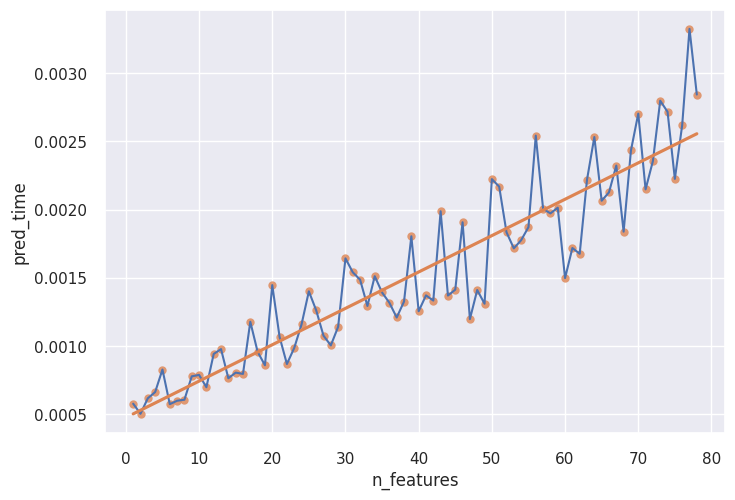

In [34]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

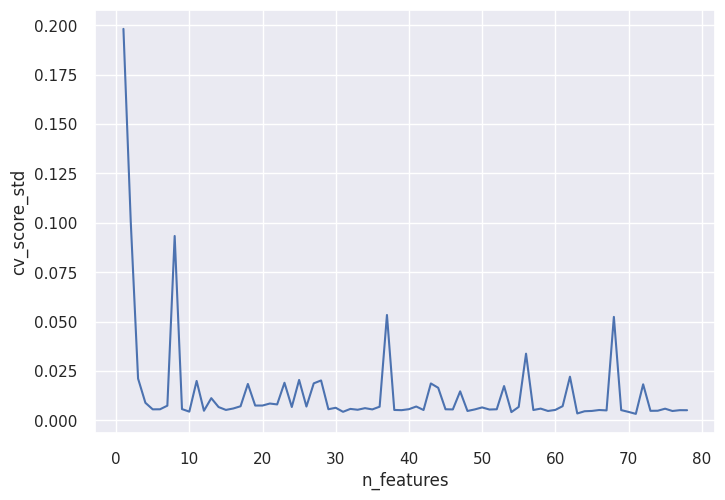

In [35]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [36]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
2,0.560401,0.554300,0.609571,0.832579,0.100563,9.158409,0.000505,1.00
1,0.474084,0.546413,0.427793,0.704591,0.198221,4.487048,0.000579,1.00
19,0.429990,0.442288,0.448533,0.935349,0.007455,4.762373,0.000860,0.75
8,0.397031,0.407486,0.410587,0.864764,0.093330,3.491784,0.000608,0.75
31,0.410686,0.400945,0.492532,0.941348,0.004281,6.859929,0.001541,0.75
...,...,...,...,...,...,...,...,...
9,0.160024,0.128724,0.237414,0.922597,0.005656,4.612672,0.000779,0.75
28,0.139232,0.112544,0.201443,0.932925,0.020165,3.366552,0.001006,0.75
48,0.076311,0.051358,0.152371,0.942604,0.004701,3.728563,0.001411,0.50


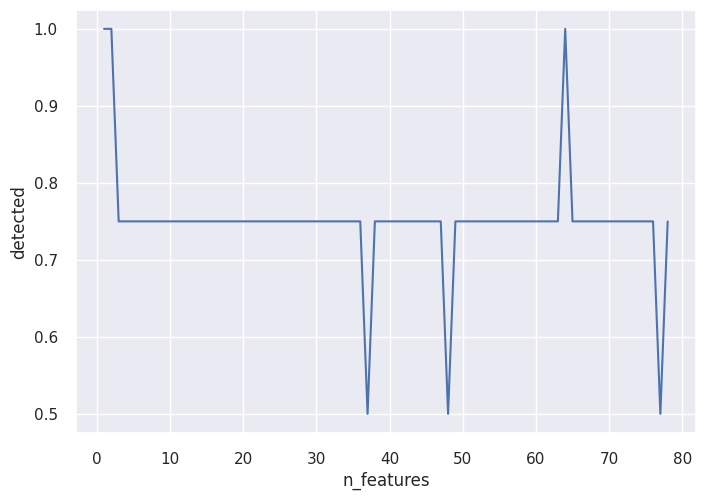

In [37]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

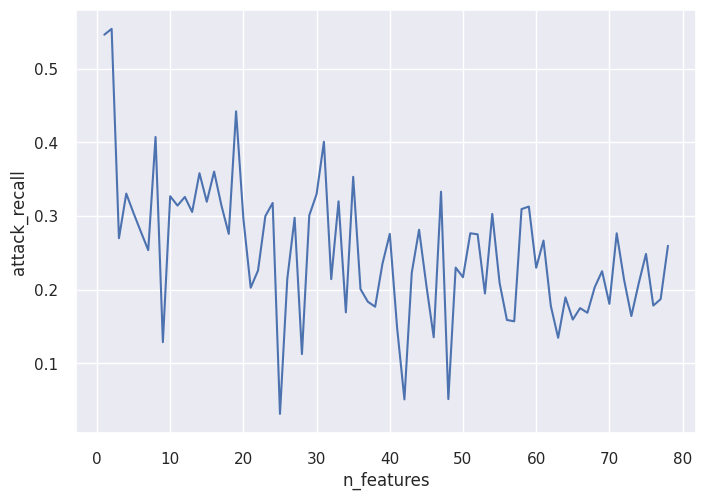

In [38]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [39]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
2,0.560401,0.554300,0.609571,0.832579,0.100563,9.158409,0.000505
1,0.474084,0.546413,0.427793,0.704591,0.198221,4.487048,0.000579
19,0.429990,0.442288,0.448533,0.935349,0.007455,4.762373,0.000860
31,0.410686,0.400945,0.492532,0.941348,0.004281,6.859929,0.001541
8,0.397031,0.407486,0.410587,0.864764,0.093330,3.491784,0.000608
...,...,...,...,...,...,...,...
9,0.160024,0.128724,0.237414,0.922597,0.005656,4.612672,0.000779
28,0.139232,0.112544,0.201443,0.932925,0.020165,3.366552,0.001006
42,0.078225,0.050983,0.173212,0.939494,0.005198,4.422741,0.001334


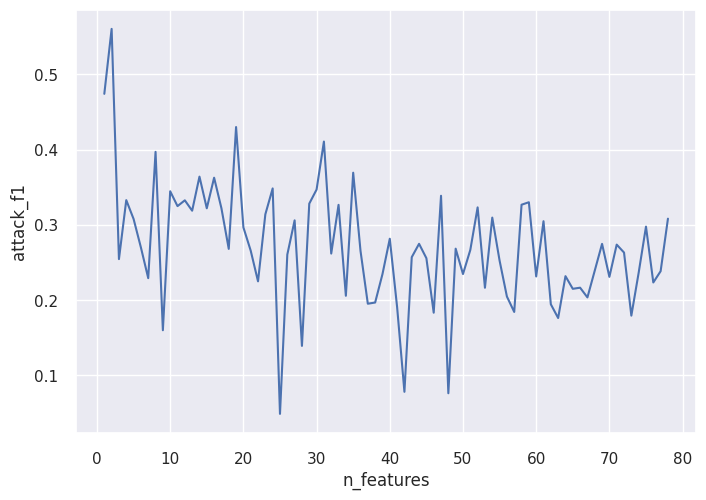

In [40]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [41]:
zero_day_feature_reduction_scores.query('n_features == 19')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
60,0.000000,0.000000,0.000000,0.957503,0.003105,19,XMRIGCC CryptoMiner,8.791930,0.000867,0
139,0.044057,0.025288,0.170897,0.935020,0.010623,19,Probing,3.817006,0.000927,1
218,0.766947,0.747121,0.787855,0.926073,0.006952,19,Bruteforce,3.167980,0.000707,1
297,0.908956,0.996745,0.835379,0.922801,0.009140,19,Bruteforce-XML,3.272575,0.000940,1


In [42]:
zero_day_feature_reduction_scores.query('n_features == 31')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
48,0.000000,0.000000,0.000000,0.964877,0.003264,31,XMRIGCC CryptoMiner,16.045612,0.001798,0
127,0.160841,0.097646,0.455874,0.946385,0.005216,31,Probing,3.846375,0.001633,1
206,0.595934,0.510140,0.716421,0.927821,0.004758,31,Bruteforce,3.253351,0.000834,1
285,0.885969,0.995994,0.797834,0.926309,0.003886,31,Bruteforce-XML,4.294380,0.001900,1
